In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['PROJ_LIB'] = '/home/jhemedinger/anaconda3/envs/cmac_env/share/proj/'
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, metrics, wait
# wait for jobs to arrive, depending on the queue, this may take some time
import dask.array as da
import dask.bag as db
import numpy as np
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, progress
import pyart
import netCDF4
import xarray
import tempfile
import shutil
from netCDF4 import num2date
import json
from scipy.ndimage.filters import gaussian_filter
#from time import strftime, sleep
import datetime
import glob
import subprocess
import matplotlib
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [ ]:
# Will run both VAD and QVP code
def run(radar_file_path, vel_field, fields, z_want, gatefilter):
    """For dask we need the radar plotting routines all in one subroutine"""
    try:
        radar = pyart.io.read(radar_file_path)
    except OSError:
        return
    
    radar_start_date = netCDF4.num2date(radar.time['data'][0], 
                                        radar.time['units'])
    time = datetime.datetime.strftime(radar_start_date, '%Y-%m-%dT%H:%M:%S')
    date = datetime.datetime.strftime(radar_start_date, '%Y%m%d')
    
    #gatefilter = pyart.filters.GateFilter(radar)
    #gatefilter.exclude_below('cross_correlation_ratio', 0.9)
    #gatefilter.exclude_above('differential_reflectivity', 1)
    
    qvp = pyart.retrieve.quasi_vertical_profile(radar, fields=fields, gatefilter=gatefilter)
    vad = pyart.retrieve.velocity_azimuth_display(radar, vel_field, z_want)
    
    data = xarray.Dataset()
    data['time'] = time
    data['qheight'] = qvp['height']
    data['temperature'] = qvp['temperature']
    data['specific_attenuation_reflectivity'] = qvp['specific_attenuation_reflectivity']
    data['specific_attenuation_differential_reflectivity'] = qvp['specific_attenuation_differential_reflectivity']
    data['radar_echo_classification'] = qvp['radar_echo_classification']
    data['reflectivity'] = qvp['reflectivity']
    data['cross_correlation_ratio'] = qvp['cross_correlation_ratio']
    data['differential_reflectivity'] = qvp['differential_reflectivity']
    data['corrected_differential_reflectivity'] = qvp['corrected_differential_reflectivity']
    data['differential_phase'] = qvp['differential_phase']
    data['corrected_differential_phase'] = qvp['corrected_differential_phase']
    data['corrected_specific_differential_phase'] = qvp['corrected_specific_differential_phase']

    data['u_wind'] = vad.u_wind
    data['v_wind'] = vad.v_wind
    data['vheight'] = vad.height
    data['speed'] = vad.speed
    data['direction'] = vad.direction
    
    data.to_netcdf('/home/jhemedinger/dev_pyart/data/20060120/' + str(time) + '.nc')
    data.close()
    
    del radar
    del qvp
    del vad
    return

In [ ]:
radar_path = '/lcrc/group/earthscience/radar/CPOL_level_1b/PPI/2006/20060120/'
fields = None
gatefilter = None
vel_field = 'region_dealias_velocity'
z_want = np.linspace(0,53515,480)

In [ ]:
if os.path.isdir(radar_path):
    radar_files = glob.glob(radar_path + '/**/*', recursive=True)

elif os.path.isfile(radar_path):
    with open(radar_path) as f:
        radar_files = f.readlines()
    radar_files = [x.strip() for x in radar_files]
else:
    raise IOError('The specified radar path does not exist!')

In [ ]:
print(len(radar_files))

In [ ]:
cluster = SLURMCluster(cores=4, job_cpu=4, walltime='01:00:00', memory='128GB', 
                      local_dir='/home/jhemedinger/dask_worker_space/', project='STARTUP-JHEMEDINGER') # change username and project name
cluster.scale(4)         # Ask for ten workers
client = Client(cluster)  # Connect this local process to remote workers

In [ ]:
cluster

In [ ]:
client

In [ ]:
def com():
    os.environ['PROJ_LIB'] = '/home/jhemedinger/anaconda3/envs/vad/share/proj/' # change username and environment name
    #from mpl_toolkits.basemap import Basemap
    return os.environ['PROJ_LIB']
client.run(com)

In [ ]:
the_bag = db.from_sequence(radar_files)
the_function = lambda x: run(x, vel_field=vel_field, z_want=z_want, fields=fields, gatefilter=gatefilter)
futures = the_bag.map(the_function)

In [ ]:
futures.compute()

In [ ]:
cluster.stop_all_jobs()

In [2]:
files = glob.glob('/home/jhemedinger/dev_pyart/data/overlay/*')
files.sort()
print(files)
print(len(files))

['/home/jhemedinger/dev_pyart/data/overlay/2006-01-24T00:00:09.nc', '/home/jhemedinger/dev_pyart/data/overlay/2006-01-24T00:10:10.nc', '/home/jhemedinger/dev_pyart/data/overlay/2006-01-24T00:20:08.nc', '/home/jhemedinger/dev_pyart/data/overlay/2006-01-24T00:30:08.nc', '/home/jhemedinger/dev_pyart/data/overlay/2006-01-24T00:40:08.nc', '/home/jhemedinger/dev_pyart/data/overlay/2006-01-24T00:50:08.nc', '/home/jhemedinger/dev_pyart/data/overlay/2006-01-24T01:00:09.nc', '/home/jhemedinger/dev_pyart/data/overlay/2006-01-24T01:10:10.nc', '/home/jhemedinger/dev_pyart/data/overlay/2006-01-24T01:20:09.nc', '/home/jhemedinger/dev_pyart/data/overlay/2006-01-24T01:30:09.nc', '/home/jhemedinger/dev_pyart/data/overlay/2006-01-24T01:40:09.nc', '/home/jhemedinger/dev_pyart/data/overlay/2006-01-24T01:50:09.nc', '/home/jhemedinger/dev_pyart/data/overlay/2006-01-24T02:00:09.nc', '/home/jhemedinger/dev_pyart/data/overlay/2006-01-24T02:10:10.nc', '/home/jhemedinger/dev_pyart/data/overlay/2006-01-24T02:20:08

In [3]:
time = []
qheight = []
temperature = []
radar_echo_classification = []
reflectivity = []
cross_correlation_ratio = []
differential_reflectivity = []
corrected_differential_reflectivity = []
differential_phase = []
corrected_differential_phase = []
corrected_specific_differential_phase = []

u_wind = []
v_wind = []
vheight = []
speed = []
direction = []

In [4]:
for file in files:
    ds = netCDF4.Dataset(file)
    t = ds['time'][:]
    qhght = ds['qheight'][:]
    temp = ds['temperature']
    rec = ds['radar_echo_classification'][:]
    ref = ds['reflectivity'][:]
    cc = ds['cross_correlation_ratio'][:]
    zdr = ds['differential_reflectivity'][:]
    czdr = ds['corrected_differential_reflectivity'][:]
    dp = ds['differential_phase'][:]
    cdp = ds['corrected_differential_phase'][:]
    csdp = ds['corrected_specific_differential_phase'][:]
    uwind = ds['u_wind'][:]
    vwind = ds['v_wind'][:]
    spd = ds['speed'][:]
    direc = ds['direction'][:]
    vhght = ds['vheight'][:]
  
    time.append(t)
    qheight.append(qhght)
    temperature.append(temp)
    radar_echo_classification.append(rec)
    reflectivity.append(ref)
    cross_correlation_ratio.append(cc)
    differential_reflectivity.append(zdr)
    corrected_differential_reflectivity.append(czdr)
    differential_phase.append(dp)
    corrected_differential_phase.append(cdp)
    corrected_specific_differential_phase.append(csdp)
    u_wind.append(uwind)
    v_wind.append(vwind)
    vheight.append(vhght)
    speed.append(spd)
    direction.append(direc)

In [5]:
new_time = np.array(time, dtype='datetime64[ns]')
new_qheight = np.array(qhght)
new_temp = np.array(temperature)
new_rec = np.array(radar_echo_classification)
new_ref = np.array(reflectivity)
new_cc = np.array(cross_correlation_ratio)
new_zdr = np.array(differential_reflectivity)
new_czdr = np.array(corrected_differential_reflectivity)
new_dp = np.array(differential_phase)
new_cdp = np.array(corrected_differential_phase)
new_csdp = np.array(corrected_specific_differential_phase)

new_u_wind = np.array(u_wind)
new_v_wind = np.array(v_wind)
new_vheight = np.array(vhght)
new_speed = np.array(speed)
new_direction = np.array(direction)
new_z = np.array(vheight)
new_q = np.array(qheight)

In [6]:
u = new_u_wind/0.514444
v = new_v_wind/0.514444
z = new_vheight/1000
C = new_speed/0.514444
t = new_time

In [7]:
btime = datetime.datetime.strftime(datetime.datetime(2006,1,24,0,0,0), '%H:%M:%S')
etime = datetime.datetime.strftime(datetime.datetime(2006,1,25,0,0,0), '%H:%M:%S')
bdate = datetime.datetime.strftime(datetime.datetime(2006,1,24), '%Y-%m-%d')
edate = datetime.datetime.strftime(datetime.datetime(2006,1,25), '%Y-%m-%d')

In [8]:
new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['cyan', 'blue', 'darkblue',
                                                                    'lime', 'green', 'darkgreen',
                                                                    'yellow', 'orange', 'darkorange',
                                                                    'red', 'firebrick', 'maroon',
                                                                    'purple', 'mediumpurple', 'rebeccapurple',
                                                                    'hotpink', 'deeppink', 'magenta',
                                                                    'pink', 'gray'])

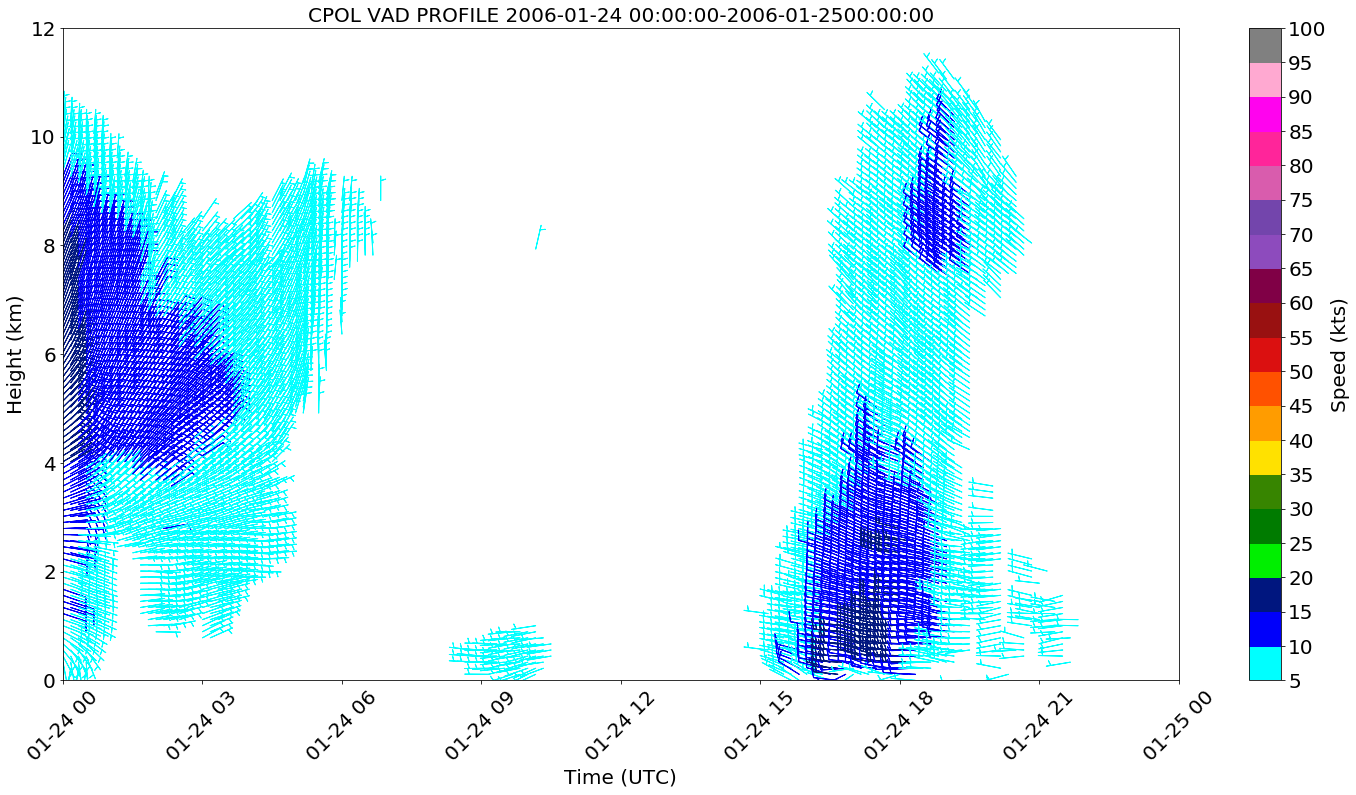

In [9]:
fig = plt.figure(figsize=[25,12])
font = { 'family' : 'normal',
            'size'   : 20 }

matplotlib.rc('font', **font)

matplotlib.rcParams.update({'font.size': 20 })
matplotlib.rcParams.update({'axes.titlesize': 20})
cmap = new_cmap
bounds = np.arange(5,105,5)
ticks = np.arange(5,105,5)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
for i in np.arange(0,144,1):
    Xq, Yq = np.meshgrid(t[i], z)
    img = plt.barbs(Xq[:,0], Yq[:,0], u[i], v[i],
                    C[i], cmap=cmap, norm=norm, 
                    sizes=dict(emptybarb=0.0), rounding=False, 
                    length=7, clip_on=True)
    
cb = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=ticks)
cb.set_label('Speed (kts)')
plt.title('CPOL VAD PROFILE ' + bdate + ' ' + btime + '-'+ edate + etime)
plt.xlim(datetime.datetime.strftime(datetime.datetime(2006,1,24,0,0,0), '%Y-%m-%dT%H:%M:%S'), 
         datetime.datetime.strftime(datetime.datetime(2006,1,25,0,0,0), '%Y-%m-%dT%H:%M:%S'))
plt.xticks(rotation=45)
plt.ylim(0, 12)
plt.ylabel('Height (km)')
plt.xlabel('Time (UTC)')
#plt.savefig('klot_hr_20181201.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

In [10]:
tgrid = np.repeat(new_time, new_z.shape[1]).reshape(new_z.shape)

In [11]:
print(tgrid.transpose().shape)
print(new_z.transpose().shape)
print(new_speed.transpose().shape)

(480, 144)
(480, 144)
(480, 144)


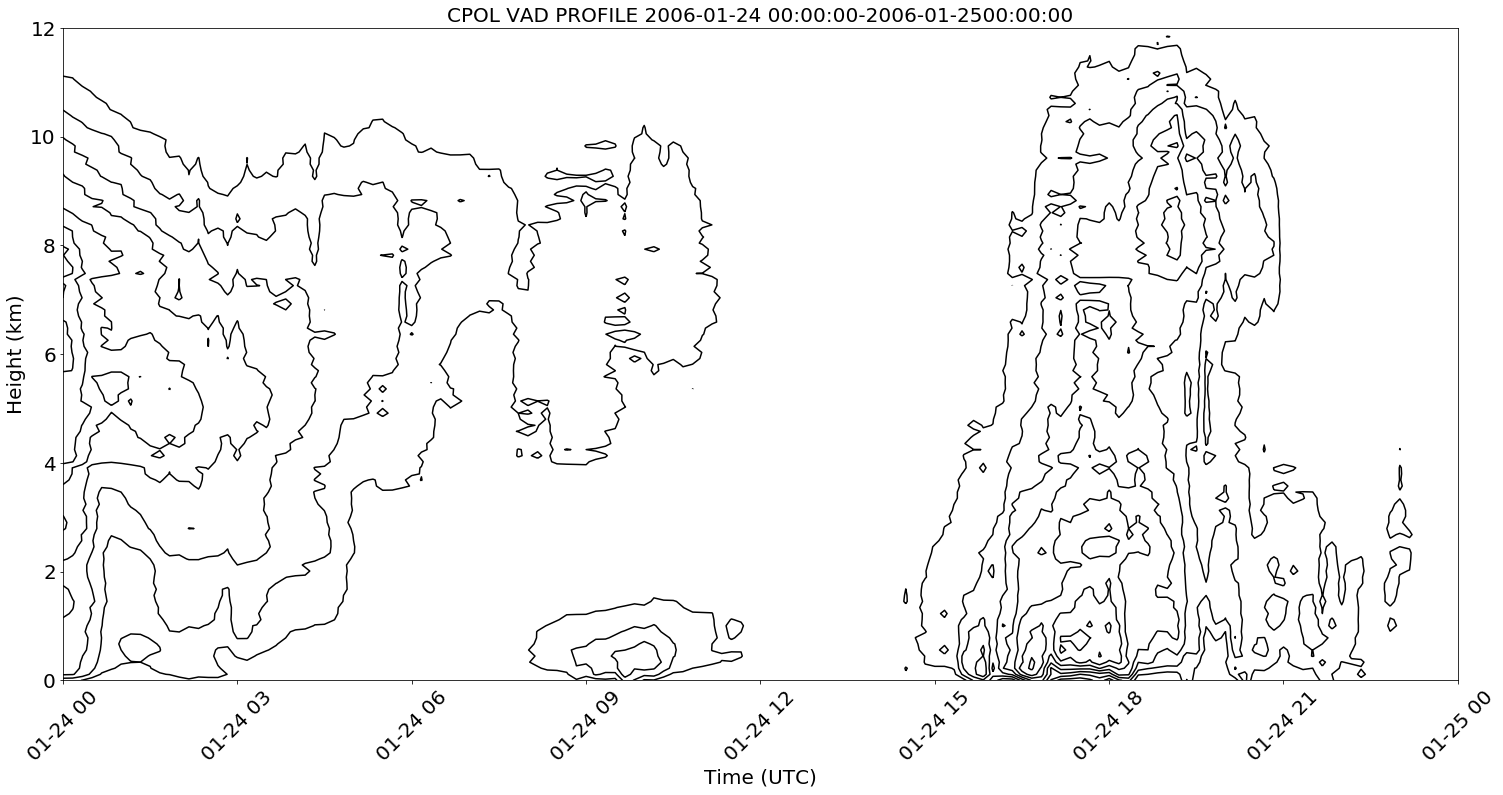

In [12]:
fig = plt.figure(figsize=[25,12])
font = { 'family' : 'normal',
            'size'   : 20 }

matplotlib.rc('font', **font)

matplotlib.rcParams.update({'font.size': 20 })
matplotlib.rcParams.update({'axes.titlesize': 20})
#cmap = new_cmap
#bounds = np.arange(5,105,5)
#ticks = np.arange(5,105,5)
#norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
#for i in np.arange(0,144,1):
#    Xq, Yq = np.meshgrid(t[i], z)
#    img = plt.barbs(Xq[:,0], Yq[:,0], u[i], v[i],
#                    C[i], cmap=cmap, norm=norm, 
#                    sizes=dict(emptybarb=0.0), rounding=False, 
#                    length=7, clip_on=False)
    
#cb = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=ticks)
#cb.set_label('Speed (kts)')
plt.contour(tgrid.transpose(), new_z.transpose()/1000, new_speed.transpose()/0.514444,
            colors=['k'])
plt.title('CPOL VAD PROFILE ' + bdate + ' ' + btime + '-'+ edate + etime)
plt.xlim(datetime.datetime.strftime(datetime.datetime(2006,1,24,0,0,0), '%Y-%m-%dT%H:%M:%S'), 
         datetime.datetime.strftime(datetime.datetime(2006,1,25,0,0,0), '%Y-%m-%dT%H:%M:%S'))
plt.xticks(rotation=45)
plt.ylim(0, 12)
plt.ylabel('Height (km)')
plt.xlabel('Time (UTC)')
#plt.savefig('klot_hr_20181201.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

In [13]:
data = gaussian_filter(new_speed.transpose(), sigma=1)

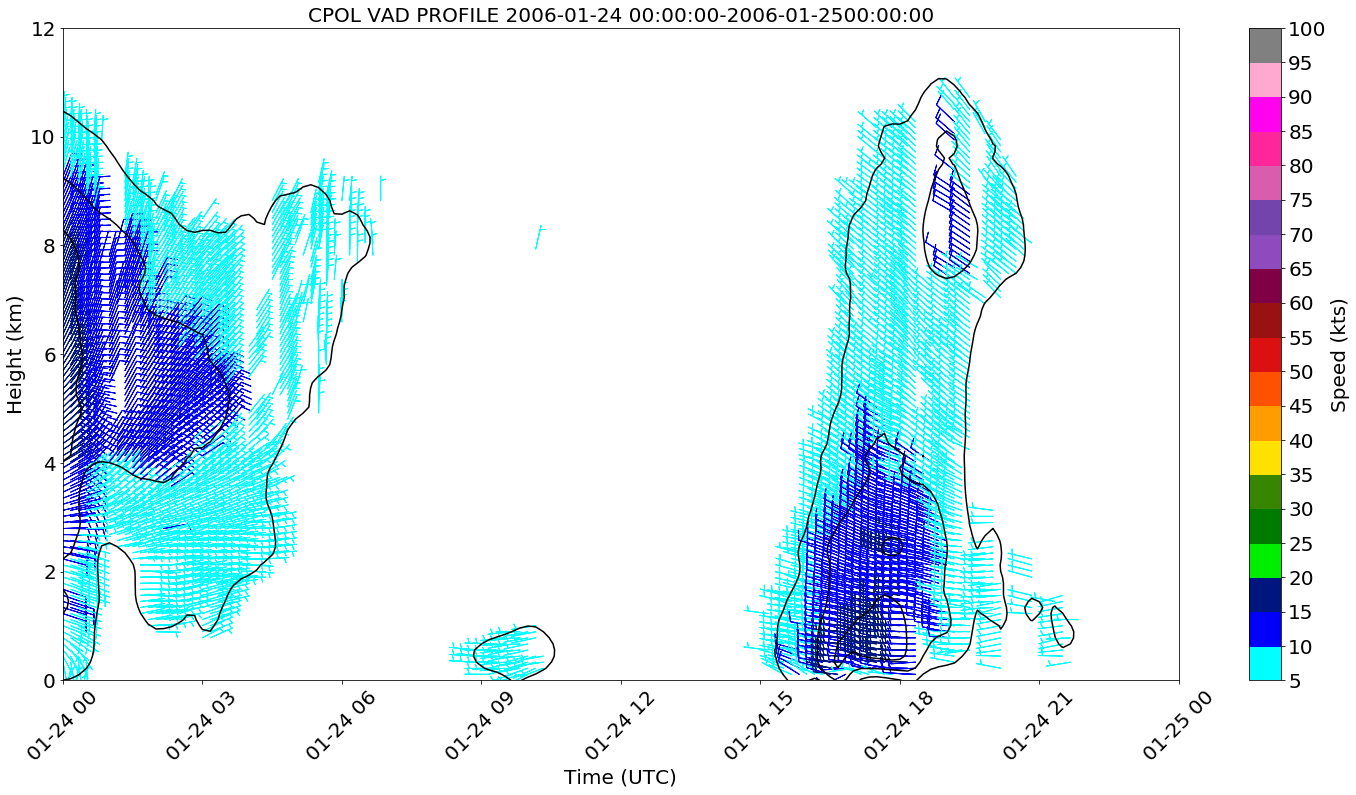

In [31]:
fig = plt.figure(figsize=[25,12])
font = { 'family' : 'normal',
            'size'   : 20 }

matplotlib.rc('font', **font)

matplotlib.rcParams.update({'font.size': 20 })
matplotlib.rcParams.update({'axes.titlesize': 20})
cmap = new_cmap
bounds = np.arange(5,105,5)
ticks = np.arange(5,105,5)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
for i in np.arange(0,144,1):
    Xq, Yq = np.meshgrid(t[i], z)
    img = plt.barbs(Xq[:,0], Yq[:,0], u[i], v[i],
                    C[i], cmap=cmap, norm=norm, 
                    sizes=dict(emptybarb=0.0), rounding=False, 
                    length=7, clip_on=True)
    
cb = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=ticks)
cb.set_label('Speed (kts)')
cs = plt.contour(tgrid.transpose(), new_z.transpose()/1000, data/0.514444,
                 colors=['k'], levels=[5,10,15,20,25], clip_on=True,
                 linestyles='solid')
#plt.clabel(cs, inline=1, fontsize=15, colors='k', fmt='%2.1f')
plt.title('CPOL VAD PROFILE ' + bdate + ' ' + btime + '-'+ edate + etime)
plt.xlim(datetime.datetime.strftime(datetime.datetime(2006,1,24,0,0,0), '%Y-%m-%dT%H:%M:%S'), 
         datetime.datetime.strftime(datetime.datetime(2006,1,25,0,0,0), '%Y-%m-%dT%H:%M:%S'))
plt.xticks(rotation=45)
plt.ylim(0, 12)
plt.ylabel('Height (km)')
plt.xlabel('Time (UTC)')
#plt.savefig('klot_hr_20181201.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

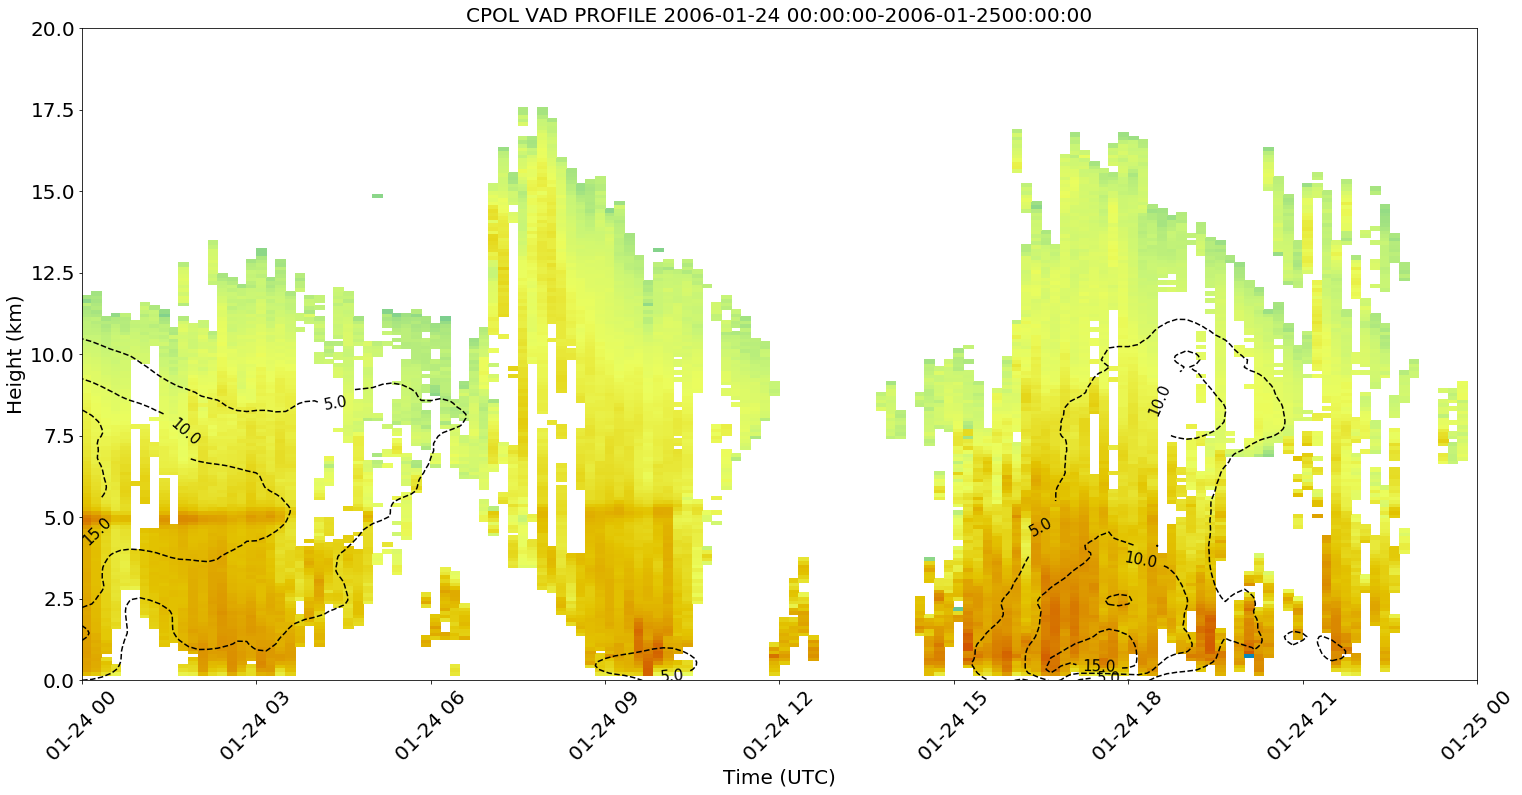

In [15]:
fig = plt.figure(figsize=[25,12])
font = { 'family' : 'normal',
            'size'   : 20 }

matplotlib.rc('font', **font)

matplotlib.rcParams.update({'font.size': 20 })
matplotlib.rcParams.update({'axes.titlesize': 20})
cmap = pyart.graph.cm_colorblind.HomeyerRainbow
img = plt.pcolormesh(new_time, new_qheight/1000, new_ref.transpose(),
                     cmap=cmap,vmin=-20, vmax=64)
cs = plt.contour(tgrid.transpose(), new_z.transpose()/1000, data/0.514444,
                 colors=['k'], levels=[5,10,15,20,25,30], clip_on=False,
                 linestyles='dashed')
plt.clabel(cs, inline=1, fontsize=15, colors='k', fmt='%2.1f')
plt.title('CPOL VAD PROFILE ' + bdate + ' ' + btime + '-'+ edate + etime)
plt.xlim(datetime.datetime.strftime(datetime.datetime(2006,1,24,0,0,0), '%Y-%m-%dT%H:%M:%S'), 
         datetime.datetime.strftime(datetime.datetime(2006,1,25,0,0,0), '%Y-%m-%dT%H:%M:%S'))
plt.xticks(rotation=45)
plt.ylim(0, 20)
plt.ylabel('Height (km)')
plt.xlabel('Time (UTC)')
#plt.savefig('cpol_20060124.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

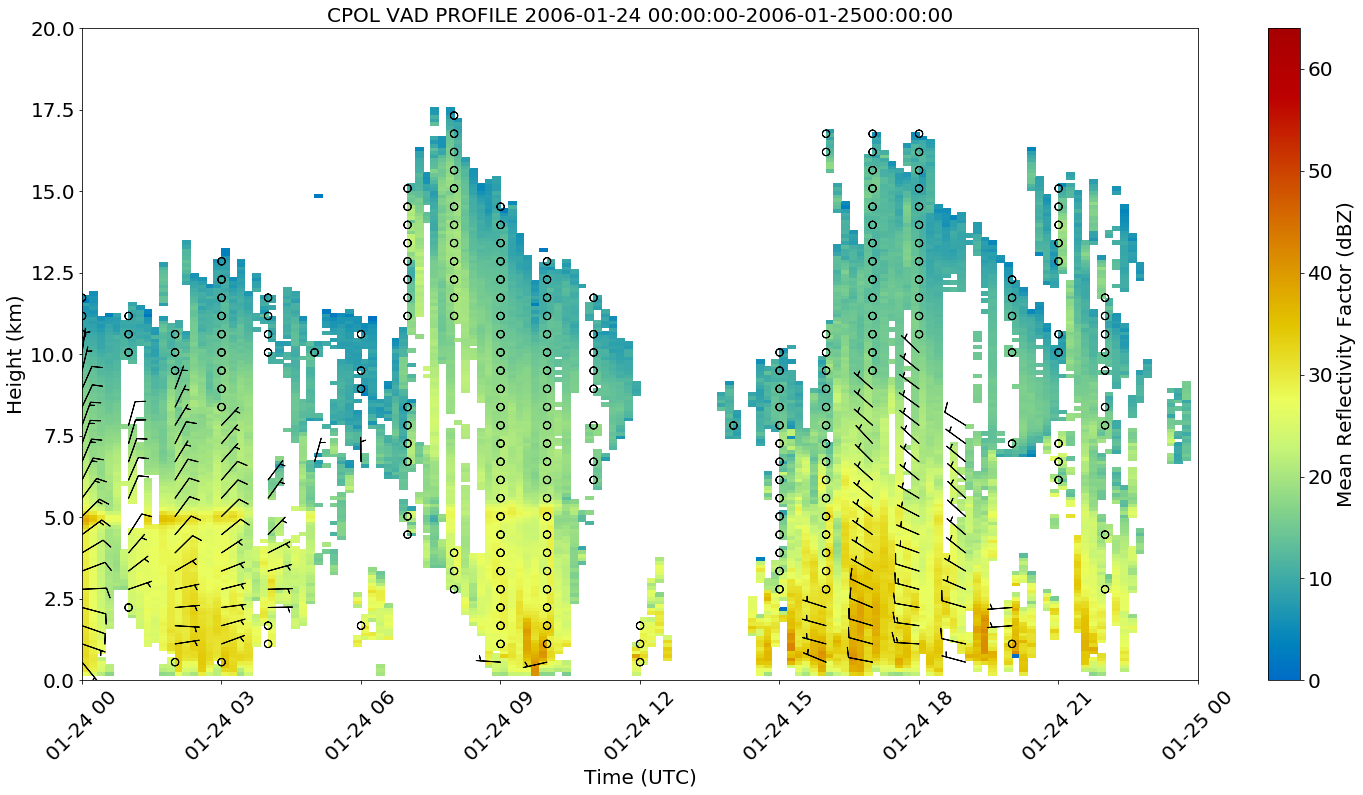

In [29]:
fig = plt.figure(figsize=[25,12])
font = { 'family' : 'normal',
            'size'   : 20 }

matplotlib.rc('font', **font)

matplotlib.rcParams.update({'font.size': 20 })
matplotlib.rcParams.update({'axes.titlesize': 20})
cmap = pyart.graph.cm_colorblind.HomeyerRainbow
img = plt.pcolormesh(new_time, new_qheight/1000, new_ref.transpose(),
                     cmap=cmap,vmin=0, vmax=64)
u = np.ma.masked_where(np.isnan(new_ref), u)
v = np.ma.masked_where(np.isnan(new_ref), v)
for i in range(len(files[::6])):
    Xq, Yq = np.meshgrid(t[::6][i], z[::5])
    plt.barbs(Xq[:,0], Yq[:,0], u[::6,::5][i], v[::6,::5][i], 
              rounding=False, 
              length=7, clip_on=True)
plt.title('CPOL VAD PROFILE ' + bdate + ' ' + btime + '-'+ edate + etime)
plt.xlim(datetime.datetime.strftime(datetime.datetime(2006,1,24,0,0,0), '%Y-%m-%dT%H:%M:%S'), 
         datetime.datetime.strftime(datetime.datetime(2006,1,25,0,0,0), '%Y-%m-%dT%H:%M:%S'))
plt.xticks(rotation=45)
plt.ylim(0, 20)
plt.ylabel('Height (km)')
plt.xlabel('Time (UTC)')
cb = plt.colorbar(img, cmap=cmap)
cb.set_label('Mean Reflectivity Factor (dBZ)')
#plt.savefig('klot_hr_20181201.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()

In [23]:
radar_path = '/lcrc/group/earthscience/radar/CPOL_level_1b/PPI/2006/20060124/cfrad.20060124_090000.000_to_20060124_090811.000_CPOL_PPI_level1b.nc'
vel_field = 'region_dealias_velocity'
z_want = np.linspace(0,10000,101)
radar = pyart.io.read(radar_path)

In [24]:
vad = pyart.retrieve.velocity_azimuth_display(radar, vel_field, z_want)

max height 2237.0 meters
max height 3963.0 meters
max height 5648.0 meters
max height 7411.0 meters
max height 9720.0 meters
max height 11987.0 meters
max height 14173.0 meters
max height 16978.0 meters
max height 20475.0 meters
max height 25000.0 meters
max height 30112.0 meters
max height 36435.0 meters
max height 44098.0 meters
max height 53261.0 meters
max height 64001.0 meters
max height 78966.0 meters
max height 96688.0 meters


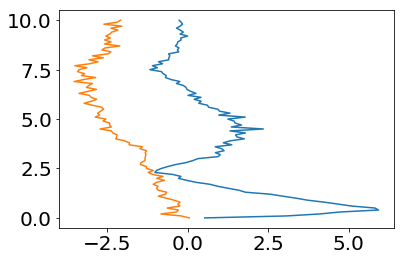

In [25]:
plt.plot(vad.u_wind/0.514444, vad.height/1000)
plt.plot(vad.v_wind/0.514444, vad.height/1000)